In [1]:
import s3fs
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import re
import geopandas as gpd
import numpy as np
import os
import matplotlib.pyplot as plt
import fiona

In [64]:
# Initialize S3 filesystem
fs = s3fs.S3FileSystem(anon=True)

# Define today and yesterday
today = datetime(2025,5,28)
# today = datetime.now().date()
yesterday = today - timedelta(days=1)

# Build candidate folder names
dates_to_try = [today, yesterday]
forecast_folders = [f"nwm.{d.strftime('%Y%m%d')}" for d in dates_to_try]

In [65]:
print(dates_to_try)
print(forecast_folders)

[datetime.datetime(2025, 5, 28, 0, 0), datetime.datetime(2025, 5, 27, 0, 0)]
['nwm.20250528', 'nwm.20250527']


In [66]:
# Find the latest valid short_range/channel_rt folder
valid_folder = None
for folder in forecast_folders:
    sr_path = f"noaa-nwm-pds/{folder}/short_range"
    try:
        files = fs.ls(sr_path)
        if any(".channel_rt." in f for f in files):
            valid_folder = sr_path
            break
    except Exception:
        continue

if not valid_folder:
    raise RuntimeError("No forecast folder with channel_rt found for today/yesterday")

print(valid_folder)

noaa-nwm-pds/nwm.20250528/short_range


In [5]:
# Select the forecast hour files of interest
forecast_hours = list(range(1, 19))  # Adjust as needed
selected_files = [
    f for f in files if (
        f.endswith(".nc") and 
        ".channel_rt." in f and 
        any(f"f{h:03d}" in f for h in forecast_hours)
    )
]
print(forecast_hours)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]


In [33]:
# Extract streamflow for a given reach_id
reach_id = 1631525  # Replace or loop through a list if needed
all_data = []
print(selected_files)

['noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f002.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f003.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f004.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f005.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f006.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f007.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f008.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f009.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f010.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm.t00z.short_range.channel_rt.f011.conus.nc', 'noaa-nwm-pds/nwm.20250702/short_range/nwm

In [67]:
# This generates a list of strings with filenames
s3path = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/nwm.20250528/netcdf/CHRTOUT/2025/nwm.t00z.short_range.channel_rt*'
remote_files = fs.glob(s3path)
print(remote_files)
print(len(remote_files))

[]
0


In [85]:
# This generates a list of strings with filenames
s3path = 's3://noaa-nwm-pds/nwm.20250528/short_range/*.channel_rt*' #nwm.t00z.short_range.channel_rt*'
remote_files = fs.glob(s3path)
print(remote_files)
print(len(remote_files))

['noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f001.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f002.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f003.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f004.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f005.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f006.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f007.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f008.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f009.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f010.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm.t00z.short_range.channel_rt.f011.conus.nc', 'noaa-nwm-pds/nwm.20250528/short_range/nwm

In [69]:

fileset = [fs.open(file) for file in remote_files]
data = xr.open_mfdataset(fileset, combine='by_coords') #, parallel = True)
print(data)

<xarray.Dataset> Size: 2GB
Dimensions:         (time: 18, feature_id: 2776734, reference_time: 1)
Coordinates:
  * time            (time) datetime64[ns] 144B 2025-05-28T01:00:00 ... 2025-0...
  * reference_time  (reference_time) datetime64[ns] 8B 2025-05-28
  * feature_id      (feature_id) int64 22MB 101 179 ... 1180001803 1180001804
Data variables:
    crs             (time) |S1 18B b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    streamflow      (time, feature_id) float64 400MB dask.array<chunksize=(1, 2776734), meta=np.ndarray>
    nudge           (time, feature_id) float64 400MB dask.array<chunksize=(1, 2776734), meta=np.ndarray>
    velocity        (time, feature_id) float64 400MB dask.array<chunksize=(1, 2776734), meta=np.ndarray>
    qSfcLatRunoff   (time, feature_id) float64 400MB dask.array<chunksize=(1, 2776734), meta=np.ndarray>
    qBucket         (time, feature_id) float64 400MB dask.array<chunksize=(1, 2776734), meta=np.ndarray>
    qBtmVertRunoff  (time, feature_id) float

In [79]:
data.reference_time

<xarray.DataArray 'reference_time' (reference_time: 1)> Size: 8B
array(['2025-05-28T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * reference_time  (reference_time) datetime64[ns] 8B 2025-05-28
Attributes:
    long_name:      model initialization time
    standard_name:  forecast_reference_time

In [ ]:
df = data.sel(feature_id=[5781223, 5781221, 5781703]).to_dataframe()
# df['init_time'] = format(pd.to_datetime(data.model_initialization_time, format = '%Y-%m-%d_%H:%M:%S'), '%Y-%m-%d %H:%M:%S')
print(df.index)
df.head()

MultiIndex([('2025-05-28 01:00:00', 5781223, '2025-05-28'),
            ('2025-05-28 01:00:00', 5781221, '2025-05-28'),
            ('2025-05-28 01:00:00', 5781703, '2025-05-28'),
            ('2025-05-28 02:00:00', 5781223, '2025-05-28'),
            ('2025-05-28 02:00:00', 5781221, '2025-05-28'),
            ('2025-05-28 02:00:00', 5781703, '2025-05-28'),
            ('2025-05-28 03:00:00', 5781223, '2025-05-28'),
            ('2025-05-28 03:00:00', 5781221, '2025-05-28'),
            ('2025-05-28 03:00:00', 5781703, '2025-05-28'),
            ('2025-05-28 04:00:00', 5781223, '2025-05-28'),
            ('2025-05-28 04:00:00', 5781221, '2025-05-28'),
            ('2025-05-28 04:00:00', 5781703, '2025-05-28'),
            ('2025-05-28 05:00:00', 5781223, '2025-05-28'),
            ('2025-05-28 05:00:00', 5781221, '2025-05-28'),
            ('2025-05-28 05:00:00', 5781703, '2025-05-28'),
            ('2025-05-28 06:00:00', 5781223, '2025-05-28'),
            ('2025-05-28 06:00:00', 5781

crs  streamflow  nudge  \
time                feature_id reference_time                           
2025-05-28 01:00:00 5781223    2025-05-28      b''        0.05  -0.01   
                    5781221    2025-05-28      b''        0.05   0.00   
                    5781703    2025-05-28      b''        0.34   0.01   
2025-05-28 02:00:00 5781223    2025-05-28      b''        0.06  -0.01   
                    5781221    2025-05-28      b''        0.05   0.00   

                                               velocity  qSfcLatRunoff  \
time                feature_id reference_time                            
2025-05-28 01:00:00 5781223    2025-05-28          0.21        0.34690   
                    5781221    2025-05-28          0.26        0.00000   
                    5781703    2025-05-28          0.40        0.00000   
2025-05-28 02:00:00 5781223    2025-05-28          0.23        0.35215   
                    5781221    2025-05-28          0.26        0.00000   

                                               qBucket  qBtmVertRunoff  
time                feature_id reference_time                           
2025-05-28 01:00:00 5781223    2025-05-28      0.15686      711.800034  
                    5781221    2025-05-28      0.04790      248.179012  
                    5781703    2025-05-28      0.06723      265.647013  
2025-05-28 02:00:00 5781223    2025-05-28      0.15696      713.563034  
                    5781221    2025-05-28      0.04796      249.403012

In [46]:
sf = data['streamflow'].sel(feature_id=reach_id).values
# sf.item() if sf.size == 1 else sf[0]
print(sf)
print(data.time.values)

[0.05 0.05 0.05 0.05 0.05 0.05 0.04 0.05 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04]
['2025-07-02T01:00:00.000000000' '2025-07-02T02:00:00.000000000'
 '2025-07-02T03:00:00.000000000' '2025-07-02T04:00:00.000000000'
 '2025-07-02T05:00:00.000000000' '2025-07-02T06:00:00.000000000'
 '2025-07-02T07:00:00.000000000' '2025-07-02T08:00:00.000000000'
 '2025-07-02T09:00:00.000000000' '2025-07-02T10:00:00.000000000'
 '2025-07-02T11:00:00.000000000' '2025-07-02T12:00:00.000000000'
 '2025-07-02T13:00:00.000000000' '2025-07-02T14:00:00.000000000'
 '2025-07-02T15:00:00.000000000' '2025-07-02T16:00:00.000000000'
 '2025-07-02T17:00:00.000000000' '2025-07-02T18:00:00.000000000']


In [41]:
len(data.feature_id.values)

2776734

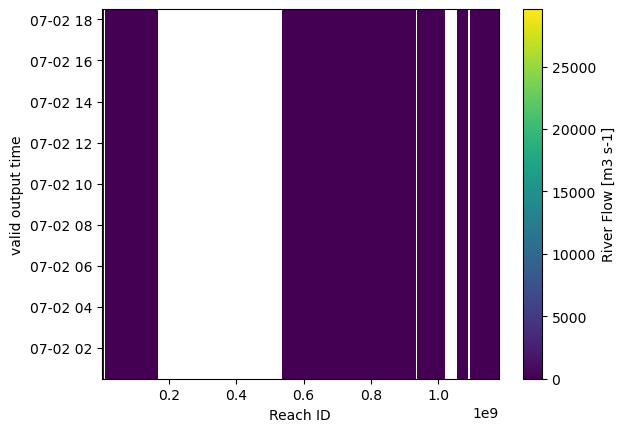

In [38]:
data.streamflow.plot()

In [37]:
data.streamflow.values

array([[1.42999997, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.42999997, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.41999997, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [1.38999997, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.38999997, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.38999997, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
for file in selected_files[0:1]: # iterating over each hour is unnecessary,  just open em all together 
    try:
        with fs.open(file) as fobj:
            ds = xr.open_dataset(fobj, engine="h5netcdf")
            sf = ds['streamflow'].sel(feature_id=reach_id).values # still downloading all of the data, just subsetting after! 
            sf_value = sf.item() if sf.size == 1 else sf[0]
            ts = pd.to_datetime(ds['time'].values).item()
            all_data.append({'timestamp': ts, 'streamflow': sf_value})
    except Exception:
        continue

In [19]:
ds

<xarray.Dataset> Size: 155MB
Dimensions:         (time: 1, reference_time: 1, feature_id: 2776734)
Coordinates:
  * time            (time) datetime64[ns] 8B 2025-07-02T01:00:00
  * reference_time  (reference_time) datetime64[ns] 8B 2025-07-02
  * feature_id      (feature_id) int64 22MB 101 179 ... 1180001803 1180001804
Data variables:
    crs             |S1 1B ...
    streamflow      (feature_id) float64 22MB ...
    nudge           (feature_id) float64 22MB ...
    velocity        (feature_id) float64 22MB ...
    qSfcLatRunoff   (feature_id) float64 22MB ...
    qBucket         (feature_id) float64 22MB ...
    qBtmVertRunoff  (feature_id) float64 22MB ...
Attributes: (12/19)
    TITLE:                      OUTPUT FROM NWM v3.0
    featureType:                timeSeries
    proj4:                      +proj=lcc +units=m +a=6370000.0 +b=6370000.0 ...
    model_initialization_time:  2025-07-02_00:00:00
    station_dimension:          feature_id
    model_output_valid_time:    2025-07-02_01:00:00
    ...                         ...
    model_configuration:        short_range
    dev_OVRTSWCRT:              1
    dev_NOAH_TIMESTEP:          3600
    dev_channel_only:           0
    dev_channelBucket_only:     0
    dev:                        dev_ prefix indicates development/internal me...

In [21]:
# Final DataFrame
nwm_df = pd.DataFrame(all_data)
nwm_df

,timestamp,streamflow
0,2025-07-02 01:00:00,0.05
